# Job Search Model

The Bellman equation representing the value of a job offer at wage $w$:
$$
v(w) = \max \left\{ \frac{w}{1-\beta}, b + \int_{W} v(w')dF(w') \right\}
$$

In [33]:
# import
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import numba

In [6]:
# set up our grid of wages
w_min = 10
w_max = 100
N = 1000
wages = np.linspace(w_min, w_max, N)  # this the support of our wage distribution

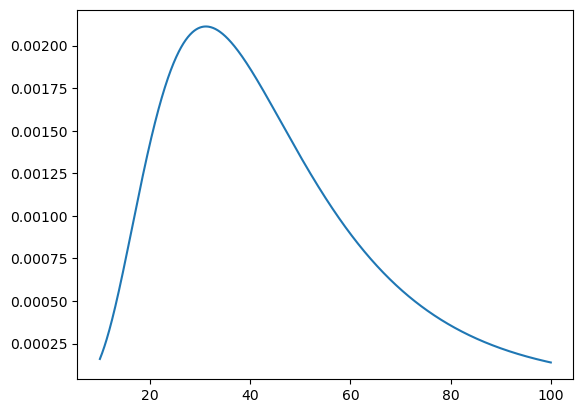

In [11]:
# create the probabilities of drawing wages w
mu = 40
sigma = 0.5
p = stats.lognorm.pdf(wages, s=sigma, scale=mu)
p = p / p.sum()
plt.plot(wages, p)

In [12]:
# Define other model parameters
beta = 0.99
theta = 0.3 # the replacement rate
b = theta * (wages * p).sum()  # the unemployment benefit

In [15]:
# Set up the fixed point algorithm
V = np.zeros(N)  # initial guess
v_tol = 1e-6
v_dist = 10
max_iter = 1000
V_matrix = np.zeros((N, max_iter))
i = 0
while (v_dist > v_tol) & (i < max_iter):
    V_matrix[:, i] = V
    value_accept = wages / (1 - beta)
    value_wait = b + beta * np.sum(V * p)
    TV = np.maximum(value_accept, value_wait)
    phi = value_accept > value_wait # the policy function
    v_dist = np.abs(V - TV).max()
    V = TV
    i += 1
    print("Iteration: ", i, "Distance: ", v_dist)




Iteration:  1 Distance:  9999.99999999999
Iteration:  2 Distance:  3241.098535044981
Iteration:  3 Distance:  738.0572454143639
Iteration:  4 Distance:  460.7099073510335
Iteration:  5 Distance:  330.37353225948937
Iteration:  6 Distance:  253.51885228506308
Iteration:  7 Distance:  202.6742881038508
Iteration:  8 Distance:  166.56065970572854
Iteration:  9 Distance:  139.63431578453037
Iteration:  10 Distance:  118.83313270138751
Iteration:  11 Distance:  102.32602485480038
Iteration:  12 Distance:  88.94497335854703
Iteration:  13 Distance:  77.91132488120638
Iteration:  14 Distance:  68.68423984783931
Iteration:  15 Distance:  60.87743528282499
Iteration:  16 Distance:  54.20653410204886
Iteration:  17 Distance:  48.45731455099394
Iteration:  18 Distance:  43.46581240062096
Iteration:  19 Distance:  39.10579650590171
Iteration:  20 Distance:  35.27503378324218
Iteration:  21 Distance:  31.893114028196578
Iteration:  22 Distance:  28.895138995304478
Iteration:  23 Distance:  26.22617

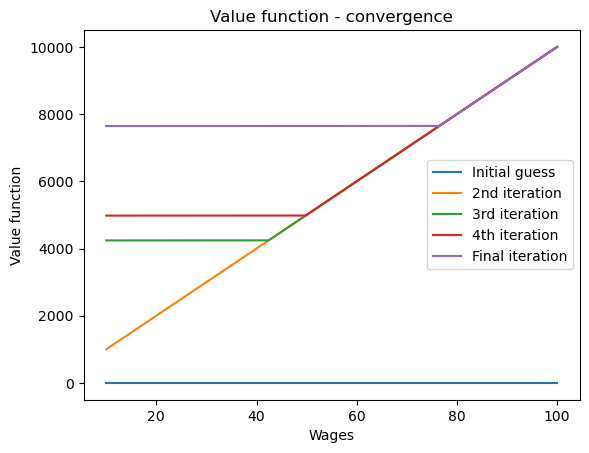

In [16]:
# Plot the value function
plt.plot(wages, V_matrix[:, 0], label='Initial guess')
plt.plot(wages, V_matrix[:, 1], label='2nd iteration')
plt.plot(wages, V_matrix[:, 2], label='3rd iteration')
plt.plot(wages, V_matrix[:, 3], label='4th iteration')
plt.plot(wages, V_matrix[:, 236], label='Final iteration')
plt.legend()
plt.xlabel('Wages')
plt.ylabel('Value function')
plt.title('Value function - convergence')
plt.show()


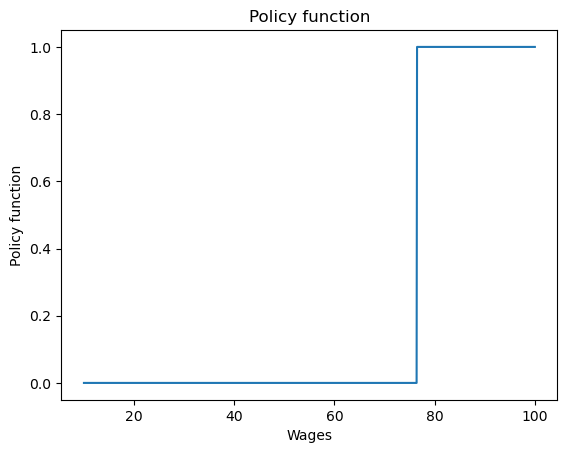

In [17]:
# Plot the policy function
plt.plot(wages, phi)
plt.xlabel('Wages')
plt.ylabel('Policy function')
plt.title('Policy function')
plt.show()

In [18]:
# what is the wage at which you always accept?
R = wages[np.argmax(phi)]
print('Reservation wage:', R)

Reservation wage: 76.48648648648648


In [20]:
def McCallModel(wages, p, beta=0.99, theta=0.3, max_iter=1000, v_tol=1e-6):
    N = len(wages)
    V = np.zeros(N)  # initial guess
    v_dist = 10
    V_matrix = np.zeros((N, max_iter))
    i = 0
    while (v_dist > v_tol) & (i < max_iter):
        V_matrix[:, i] = V
        value_accept = wages / (1 - beta)
        value_wait = b + beta * np.sum(V * p)
        TV = np.maximum(value_accept, value_wait)
        phi = value_accept > value_wait # the policy function
        v_dist = np.abs(V - TV).max()
        V = TV
        i += 1
    R = wages[np.argmax(phi)]
    return V, phi, R


In [22]:
V, phi, R = McCallModel(wages, p)
print('Reservation wage:', R)

Reservation wage: 76.48648648648648


In [23]:
V, phi, R = McCallModel(wages, p, beta=0.95)
print('Reservation wage:', R)

Reservation wage: 60.45045045045045


In [30]:
def McCallModel_loop(wages, p, beta=0.99, theta=0.3, max_iter=1000, v_tol=1e-6):
    N = len(wages)
    V = np.zeros(N)  # initial guess
    v_dist = 10
    V_matrix = np.zeros((N, max_iter))
    i = 0
    while (v_dist > v_tol) & (i < max_iter):
        V_matrix[:, i] = V
        value_accept = np.zeros(N)
        value_wait = b
        TV = np.zeros(N)
        for j in range(N):
            value_accept[j] = wages[j] / (1 - beta)
            value_wait +=  beta * V[j] * p[j]
        TV = np.maximum(value_accept, value_wait)
        phi = value_accept > value_wait # the policy function
        v_dist = np.abs(V - TV).max()
        V = TV
        i += 1
    R = wages[np.argmax(phi)]
    return V, phi, R

In [31]:
V, phi, R = McCallModel_loop(wages, p)
print('Reservation wage:', R)

Reservation wage: 76.48648648648648


# How slow are loop in Python?

In [32]:
%timeit McCallModel(wages, p)
%timeit McCallModel_loop(wages, p)

2.76 ms ± 67.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
92.8 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# How to write fast loops?  Numba!

In [34]:
from numba import jit

In [35]:
@jit
def accept_values(wages, p, beta, b, V, N):
    value_accept = np.zeros(N)
    value_wait = b
    for j in range(N):
        value_accept[j] = wages[j] / (1 - beta)
        value_wait +=  beta * V[j] * p[j]
    return value_accept, value_wait


def McCallModel_numba(wages, p, beta=0.99, theta=0.3, max_iter=1000, v_tol=1e-6):
    N = len(wages)
    V = np.zeros(N)  # initial guess
    v_dist = 10
    V_matrix = np.zeros((N, max_iter))
    i = 0
    while (v_dist > v_tol) & (i < max_iter):
        V_matrix[:, i] = V
        value_accept, value_wait = accept_values(wages, p, beta, b, V, N)
        TV = np.maximum(value_accept, value_wait)
        phi = value_accept > value_wait # the policy function
        v_dist = np.abs(V - TV).max()
        V = TV
        i += 1
    R = wages[np.argmax(phi)]
    return V, phi, R

In [36]:
%timeit McCallModel(wages, p)
%timeit McCallModel_loop(wages, p)
%timeit McCallModel_numba(wages, p)

2.72 ms ± 59.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
91.5 ms ± 494 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.47 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Another contraction mapping

$$
h = b + \beta \int_W max \left\{ \frac{w}{1-\beta}, h \right\} dF(w)
$$

In [44]:
def McCallModel_v2(wages, p, beta=0.99, theta=0.3, max_iter=1000, h_tol=1e-6):
    h = 0 # initial guess
    h_dist = 10
    iter = 0
    b = theta * (wages * p).sum()
    while (h_dist > h_tol) & (iter < max_iter):
        Th = b + beta * np.sum(np.maximum(wages / (1-beta), h) * p)
        h_dist = np.abs(h - Th)
        h = Th
        iter += 1
    R = (1 - beta) * h
    return R


In [45]:
R = McCallModel_v2(wages, p)
print('Reservation wage:', R)

Reservation wage: 76.4535581820721


In [43]:
V, phi, R = McCallModel(wages, p)
print('Reservation wage:', R)

Reservation wage: 76.48648648648648


In [46]:
%timeit McCallModel_v2(wages, p)
%timeit McCallModel(wages, p)

1.3 ms ± 7.71 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.69 ms ± 25.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Comparative statics

In [47]:
# How does R change as the replacement rate changes?
theta_vals = np.linspace(0, 1.0, 100)
R_vals = np.zeros(100)
for i, theta in enumerate(theta_vals):
    R_vals[i] = McCallModel_v2(wages, p, theta=theta)

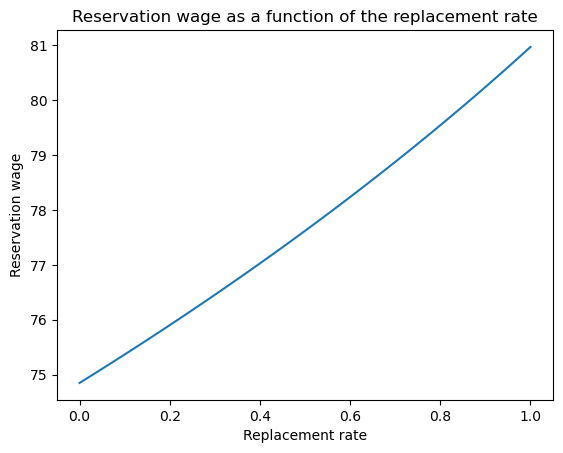

In [48]:
plt.plot(theta_vals, R_vals)
plt.xlabel('Replacement rate')
plt.ylabel('Reservation wage')
plt.title('Reservation wage as a function of the replacement rate')
plt.show()

In [49]:
# How does unemployment duration changes as the replacement rate changes?
# start by randomly drawing a wage
T = 1000
S = 1000
wage_draws = np.random.choice(wages, size=T*S, p=p)
wage_draws = wage_draws.reshape((T, S))
mean_time_to_accept = np.zeros_like(theta_vals)
for i, theta in enumerate(theta_vals):
    R = McCallModel_v2(wages, p, theta=theta)
    # compare R to the wage draws
    time_to_accept = np.argmax(wage_draws >= R, axis=0)  # the first time the wage is above the reservation wage, in the T dimension
    mean_time_to_accept[i] = time_to_accept.mean()


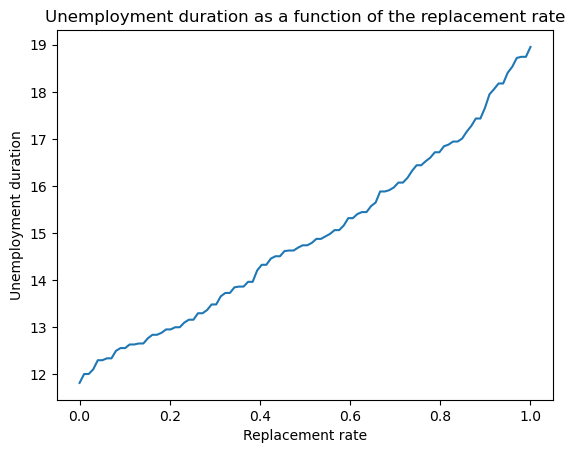

In [50]:
# plot unemployment duration as a function of the replacement rate
plt.plot(theta_vals, mean_time_to_accept)
plt.xlabel('Replacement rate')
plt.ylabel('Unemployment duration')
plt.title('Unemployment duration as a function of the replacement rate')
plt.show()

In [52]:
# What if we have a different wage distribution?
# e.g., what is sigma changes?
sigma_vals = np.linspace(0.1, 1.0, 100)
R_vals = np.empty_like(sigma_vals)
for i, sigma in enumerate(sigma_vals):
    p = stats.lognorm.pdf(wages, s=sigma, scale=mu)
    p = p / p.sum()  # normalize the probabilities
    R_vals[i] = McCallModel_v2(wages, p)



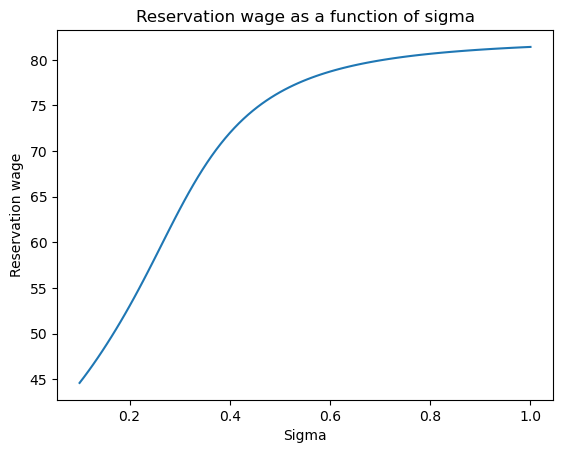

In [53]:
# plot reservation wage as a function of sigma
plt.plot(sigma_vals, R_vals)
plt.xlabel('Sigma')
plt.ylabel('Reservation wage')
plt.title('Reservation wage as a function of sigma')
plt.show()